In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import scanpy as sc
import h5py

import sys

print(f'PID number is {os.getpid()}')

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

PID number is 19508


# Load adata and genotype

In [2]:
majorType_to_subcls = {'Gluta':['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 'L5 ET', 'L5/6 NP', 'L6 CT', 'L6b'],
                      'GABA':['Lamp5', 'Sncg', 'Vip', 'Sst', 'Pvalb'],
                      'Astro':['Astro'], 'Oligo':['Oligo', 'OPC'], 'Micro':['Micro'],
                      'Endo': ['Peri', 'SMC-VLMC', 'Endo-PVM']}
subcls_to_majorType = {'other':'other'}
for majortype, subcls_list in majorType_to_subcls.items():
    for subcls in subcls_list:
        subcls_to_majorType[subcls]=majortype

In [3]:
# load adata
adata = sc.read_h5ad(r"MeCP2_clustered_adata_labeled.h5ad")
# load Mecp2 info
df_cell_with_MeCP2 = pd.read_csv(r'all_cells_info.csv', index_col=0)
uid_to_genotype = {uid:genotype for (uid,genotype) in zip(df_cell_with_MeCP2.uid, df_cell_with_MeCP2.genotype)}
adata.obs['cell_uid'] = adata.obs.index
adata.obs['genotype'] = adata.obs['cell_uid'].apply(lambda x: uid_to_genotype[x] if x in uid_to_genotype.keys() else 'ND')
adata.obs.drop(columns='cell_uid', inplace=True)
# add major type info
adata.obs['majorType'] = adata.obs['subclass'].apply(lambda x: subcls_to_majorType[x])
# save df
df_cells = adata.obs[(adata.obs.genotype!='ND')&(adata.obs.subclass!='other')].copy()
df_cells.to_csv(mecp2_df_name)

In [4]:
df_cells

,uid,fov,volume,center_x,center_y,min_x,max_x,min_y,max_y,experiment,...,age,n_genes_by_counts,total_counts,subclass,genotype,majorType,hemisphere,WT_over_KO_ratio,Neuron_identity,region
0,100488189023469889594930787401453076425,0,278.808456,-230.986007,-85.670002,-234.506807,-227.465207,-89.190802,-82.149202,722,...,2.5_month,45,139.0,Oligo,WT,Oligo,0,0.086379,Non-neuron,gray_matter
1,118810555376811432243045980692848875157,0,237.102888,-327.538010,-47.330001,-331.058810,-324.017210,-50.742801,-43.917201,722,...,2.5_month,27,53.0,Oligo,KO,Oligo,0,0.103093,Non-neuron,white_matter
2,121417342135746412542665712718583471561,0,526.141489,-250.426008,-2.726000,-255.458808,-245.393208,-7.758800,2.306800,722,...,2.5_month,111,371.0,L6 CT,WT,Gluta,0,0.086379,Neuron,gray_matter
3,124389021119147953283597291342420762196,0,336.097361,-387.478011,51.382002,-390.674811,-384.281211,47.105202,55.658802,722,...,2.5_month,89,296.0,L6 CT,KO,Gluta,0,0.086379,Neuron,gray_matter
4,127693129422583023643028565550459932489,0,206.077230,-392.446011,34.750001,-395.210812,-389.681211,31.553201,37.946801,722,...,2.5_month,88,237.0,Sncg,WT,GABA,0,0.086379,Neuron,gray_matter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122872,94651392123118829088321465793420452012,255,204.060174,1189.005992,127.702004,1185.269192,1192.742792,123.749204,131.654804,1107,...,6_month,85,213.0,L5 ET,KO,Gluta,3,0.805628,Neuron,gray_matter
122873,94750795428183338673959299756273926819,255,331.448090,1187.061992,141.418004,1182.893192,1191.230792,138.005204,144.830804,1107,...,6_month,36,164.0,Endo-PVM,KO,Endo,3,0.805628,Non-neuron,gray_matter
122874,9632407225474561357286622891005710050,255,455.537194,1181.445992,24.670001,1176.197192,1186.694792,20.069201,29.270801,1107,...,6_month,125,457.0,L6 CT,WT,Gluta,3,0.805628,Neuron,gray_matter
122875,98298778356884828414810266217154971015,255,319.996375,1078.845989,33.094002,1073.813189,1083.878790,30.005202,36.182802,1107,...,6_month,119,379.0,L5 ET,WT,Gluta,3,0.805628,Neuron,gray_matter


# Dataframe for majortypes

In [5]:
# generate dataframe for young ages
dict_young = {}
dict_young['WT'] = []
dict_young['KO'] = []

df_wt = df_cells[(df_cells.age=='2.5_month')&(df_cells.genotype=='WT')].copy()
df_ko = df_cells[(df_cells.age=='2.5_month')&(df_cells.genotype=='KO')].copy()

for majortype in majorTypes:
    _wt_percentage = len(df_wt[df_wt.majorType==majortype])/len(df_wt)*100
    _ko_percentage = len(df_ko[df_ko.majorType==majortype])/len(df_ko)*100
    dict_young['WT'].append(_wt_percentage)
    dict_young['KO'].append(_ko_percentage)

dict_young['majorType'] = majorTypes
    
df_young = pd.DataFrame(dict_young)
df_young.set_index('majorType', inplace=True)
df_young = df_young.transpose()
df_young

majorType,Gluta,GABA,Astro,Oligo,Micro,Endo
WT,52.501724,10.288110,8.860827,15.222582,1.676659,11.450098
KO,53.616463,8.812638,9.454835,16.331505,2.156284,9.628275


In [6]:
# generate dataframe for young ages
dict_old = {}
dict_old['WT'] = []
dict_old['KO'] = []

df_wt = df_cells[(df_cells.age=='6_month')&(df_cells.genotype=='WT')].copy()
df_ko = df_cells[(df_cells.age=='6_month')&(df_cells.genotype=='KO')].copy()

for majortype in majorTypes:
    _wt_percentage = len(df_wt[df_wt.majorType==majortype])/len(df_wt)*100
    _ko_percentage = len(df_ko[df_ko.majorType==majortype])/len(df_ko)*100
    dict_old['WT'].append(_wt_percentage)
    dict_old['KO'].append(_ko_percentage)

dict_old['majorType'] = majorTypes
    
df_old = pd.DataFrame(dict_old)
df_old.set_index('majorType', inplace=True)
df_old = df_old.transpose()
df_old

majorType,Gluta,GABA,Astro,Oligo,Micro,Endo
WT,52.450453,10.053813,8.392177,16.419478,1.840137,10.843943
KO,55.685844,8.394242,8.221604,14.880499,1.553742,11.264069


## Plot for majortypes

In [7]:
mpl.rc('figure', dpi=300)
mpl.rc('figure', titlesize=10.) 
mpl.rc('figure.constrained_layout', use=True)

mpl.rc('axes', labelsize=8.)
mpl.rc('axes', titlesize=9.)
mpl.rc('axes', linewidth=0.5)

mpl.rc('font', family='Arial')

mpl.rc('savefig', dpi=300)
mpl.rc('savefig', format='pdf')

mpl.rc('xtick', labelsize=7.)
mpl.rc('xtick.major', size=3)
mpl.rc('xtick.major', width=1.)

mpl.rc('ytick', labelsize=7.)
mpl.rc('ytick.major', size=3)
mpl.rc('ytick.major', width=1.)

mpl.rcParams['pdf.fonttype'] = 42

figure_folder = r'results\cell_composition'

meta NOT subset; don't know how to subset; dropped


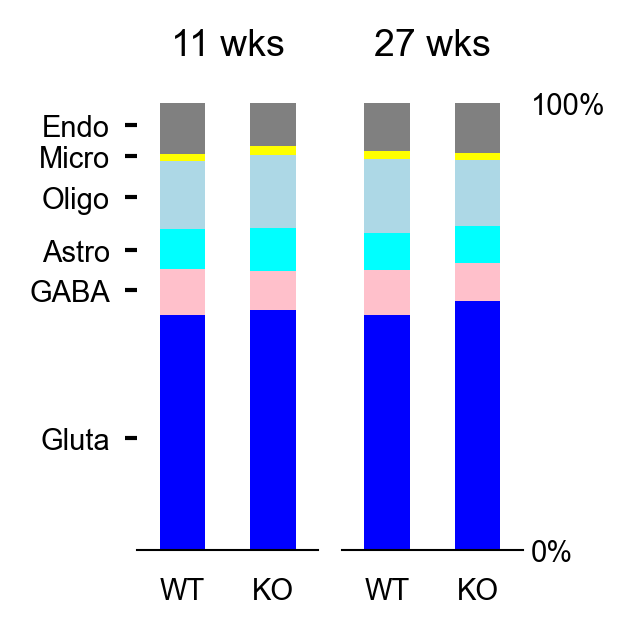

In [9]:
fig = plt.figure(figsize=(2,2), dpi=300)

colors = ['blue', 'pink', 'cyan', 'lightblue', 'yellow', 'gray']

ax1_yticks = [25, 58, 67, 79, 88, 95]

ax1 = fig.add_subplot(121)
df_young.plot(kind='bar', stacked=True, color=colors, ax=ax1, legend=False)
ax1.tick_params(axis='x', labelrotation=0)
ax1.set_yticks(ax1_yticks, majorTypes)
ax1.set_title('11 wks')
ax1.tick_params(bottom=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(True)

ax2 = fig.add_subplot(122)
df_old.plot(kind='bar', stacked=True, color=colors, ax=ax2, legend=False)
ax2.set_yticks([0, 100], ['0%', '100%'])
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.tick_params(axis='x', labelrotation=0)
ax2.tick_params(axis='y', pad=-1)
ax2.tick_params(right=False, bottom=False)
ax2.set_title('27 wks')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(True)

figure_name = os.path.join(figure_folder, 'majorType_composition.svg')
plt.savefig(figure_name)
plt.savefig(figure_name.replace('svg', 'png'))
plt.savefig(figure_name.replace('svg', 'pdf'))

plt.show()